In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn import metrics

from ast import literal_eval

from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression


import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_length = 15000
stocks = ['9064', '9061', '9265']
should_save_fig = False

In [3]:
d_stocks = {}
d_cv_stocks = {}
d_test_stocks = {}
for s in stocks:
    d,  d_test = lob.load_prepared_data(
        s, data_dir='../queue_imbalance/data/prepared', cv=False, length=data_length)
    d.index = pd.to_datetime(d['Unnamed: 0'].values)
    d_test.index = pd.to_datetime(d_test['Unnamed: 0'].values)
    d['prev_queue_imbalance'] = [None] + d['queue_imbalance'].iloc[0:len(d)-1].values.tolist()
    d.dropna(inplace=True)
    d_test['prev_queue_imbalance'] = [None] + d_test['queue_imbalance'].iloc[0:len(d_test)-1].values.tolist()
    d_test.dropna(inplace=True)
    d_stocks[s] = d
    d_test_stocks[s] = d_test

In [4]:
d_stocks['9061'].head()

,Unnamed: 0,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance,prev_queue_imbalance
2013-09-13 10:37:00,2013-09-13 10:37:00,"[(550.0, 6364.0), (615.0, 2514.0), (630.0, 151...","[(699.3, 9528.0), (699.4, 17958.0), (699.5, 28...",699.1,699.3,699.20,9528.0,3722.0,1.0,-0.438189,0.399368
2013-09-13 10:39:00,2013-09-13 10:39:00,"[(550.0, 6364.0), (615.0, 2514.0), (630.0, 151...","[(699.5, 3954.0), (699.6, 10269.0), (699.7, 16...",699.4,699.5,699.45,3954.0,4580.0,0.0,0.073354,-0.438189
2013-09-13 10:40:00,2013-09-13 10:40:00,"[(550.0, 6364.0), (615.0, 2514.0), (630.0, 151...","[(699.5, 3724.0), (699.6, 11982.0), (699.7, 16...",699.3,699.5,699.40,3724.0,8567.0,1.0,0.394028,0.073354
2013-09-13 10:41:00,2013-09-13 10:41:00,"[(550.0, 6364.0), (615.0, 2514.0), (630.0, 151...","[(699.6, 458.0), (699.7, 13014.0), (699.8, 334...",699.5,699.6,699.55,458.0,3667.0,0.0,0.777939,0.394028
2013-09-13 10:42:00,2013-09-13 10:42:00,"[(550.0, 6364.0), (615.0, 2514.0), (630.0, 151...","[(699.4, 8370.0), (699.5, 19897.0), (699.6, 16...",699.1,699.4,699.25,8370.0,6055.0,1.0,-0.160485,0.777939


## SVM with queue imbalance

In [5]:
df_res = {}
for s in stocks:
    df_res_temp = pd.read_csv('res_{}_prev_queue_imbalance.csv'.format(s))
    df_res_temp = df_res_temp[df_res_temp['features'] == 'queue_imbalance']
    df_res_temp = df_res_temp[df_res_temp['method'] != 'logistic']
    df_res_temp['stock'] = [s for i in range(len(df_res_temp))]
    df_res[s] = df_res_temp
    columns_to_mean = ['f1', 'kappa', 'matthews', 
       'precision', 'recall', 'roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc']
    for c in columns_to_mean:
        cc = []
        for i, row in df_res[s].iterrows():
            cc.append(np.array(literal_eval(row[c])).mean())
        df_res[s][c] = cc

In [6]:
df_res['9265']['method'].unique()

array(['svm_sigmoid', 'svm_rbf', 'svm_linear'], dtype=object)

In [7]:
df_res['9064'].sort_values(by='matthews', ascending=False).head()

,Unnamed: 0,f1,features,kappa,matthews,method,precision,recall,roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc,c,coef0,gamma,stock
69,69,0.530123,queue_imbalance,0.089783,0.090322,svm_sigmoid,0.554969,0.509007,0.544999,0.532894,0.084606,0.085056,0.554890,0.513708,0.542376,1.00,1.0,0.10,9064
37,37,0.529792,queue_imbalance,0.087089,0.087562,svm_sigmoid,0.553285,0.509671,0.543646,0.533873,0.084272,0.084673,0.554448,0.515796,0.542204,100.00,1.0,0.01,9064
35,35,0.545645,queue_imbalance,0.086527,0.086784,svm_sigmoid,0.549780,0.542922,0.543343,0.548727,0.081290,0.081325,0.549609,0.548068,0.540650,100.00,0.1,0.01,9064
351,351,0.541052,queue_imbalance,0.086271,0.086611,svm_rbf,0.550559,0.533485,0.543239,0.542409,0.078850,0.078895,0.549289,0.535829,0.539446,0.01,NaN,1000.00,9064
243,243,0.541052,queue_imbalance,0.086271,0.086611,svm_sigmoid,0.550559,0.533485,0.543239,0.542409,0.078850,0.078895,0.549289,0.535829,0.539446,0.01,0.1,1000.00,9064


In [8]:
df_best_svm = pd.DataFrame()
for s in stocks:
    idx_max = df_res[s]['matthews'].idxmax()
    df_best_svm = df_best_svm.append(df_res[s].loc[idx_max])
df_best_svm

,Unnamed: 0,c,coef0,f1,features,gamma,kappa,matthews,method,precision,recall,roc_auc,stock,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
69,69.0,1.0,1.0,0.530123,queue_imbalance,0.1,0.089783,0.090322,svm_sigmoid,0.554969,0.509007,0.544999,9064,0.532894,0.084606,0.085056,0.554890,0.513708,0.542376
309,309.0,10.0,NaN,0.472840,queue_imbalance,0.1,0.083457,0.084116,svm_rbf,0.489507,0.460222,0.541780,9061,0.465221,0.082093,0.082218,0.477822,0.453403,0.540977
69,69.0,1.0,1.0,0.557741,queue_imbalance,0.1,0.103891,0.104873,svm_sigmoid,0.561875,0.558804,0.551917,9265,0.554848,0.104753,0.104827,0.550536,0.559560,0.552398


In [9]:
print(df_best_svm[['stock', 'method', 'c', 'gamma', 'coef0']].to_latex())

\begin{tabular}{lllrrr}
\toprule
{} & stock &       method &     c &  gamma &  coef0 \\
\midrule
69  &  9064 &  svm\_sigmoid &   1.0 &    0.1 &    1.0 \\
309 &  9061 &      svm\_rbf &  10.0 &    0.1 &    NaN \\
69  &  9265 &  svm\_sigmoid &   1.0 &    0.1 &    1.0 \\
\bottomrule
\end{tabular}



In [10]:
def fit_best_svm_classifier(df_best_svm, df, stock=None):
    gamma = df_best_svm[df_best_svm['stock'] == stock]['gamma'].values[0]
    coef0 = df_best_svm[df_best_svm['stock'] == stock]['coef0'].values[0]
    c = df_best_svm[df_best_svm['stock'] == stock]['c'].values[0]
    kernel = df_best_svm[df_best_svm['stock'] == stock]['method'].values[0].split('_')[1]

    X = df['queue_imbalance'].values.reshape(-1, 1)
    y = df['mid_price_indicator']
    
    clf = SVC(gamma=gamma, C=c, coef0=coef0, kernel=kernel, random_state=23131)
    clf.fit(X, y)
    return clf
    

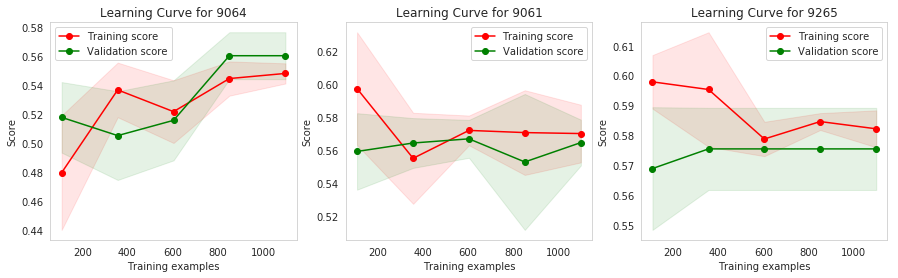

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit

f, ax = plt.subplots(1, 3, figsize=(15,4))
i = 0
for stock in stocks:
    log_clf = fit_best_svm_classifier(df_best_svm, d_stocks[stock], stock=stock)
    lob.plot_learning_curve(
        log_clf, d_stocks[stock]['queue_imbalance'].values.reshape(-1, 1),
        d_stocks[stock]['mid_price_indicator'], 
        cv=TimeSeriesSplit(n_splits=10, max_train_size=9000), ax=ax[i], scoring='roc_auc')
    ax[i].set_title('Learning Curve for {}'.format(stock))
    i += 1
if should_save_fig:
    print('Saving')
    plt.savefig('svm_learning_curves.png')

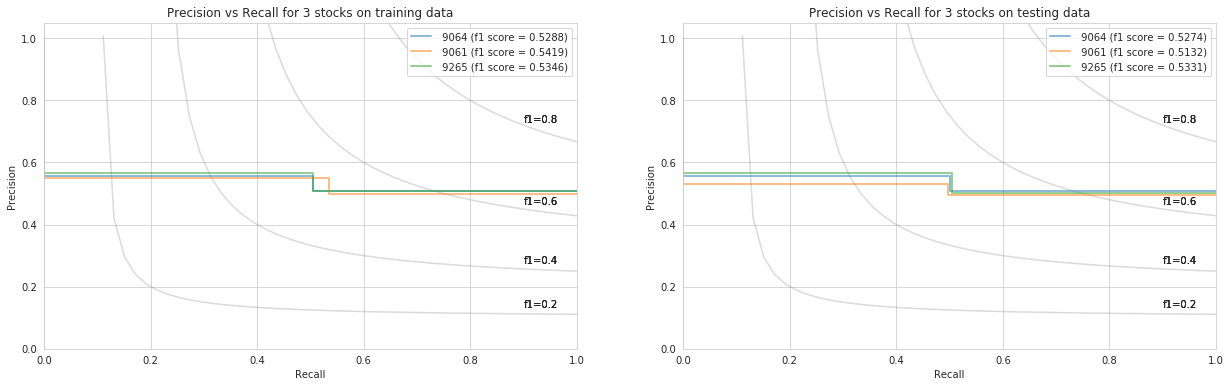

In [12]:
f, (ax1, ax3) = plt.subplots(1, 2, figsize=(21,6))
for stock in stocks:
    log_clf = fit_best_svm_classifier(df_best_svm, d_stocks[stock], stock=stock)
    pred_train = log_clf.predict(d_stocks[stock]['queue_imbalance'].values.reshape(-1, 1))
    pred_test = log_clf.predict(d_test_stocks[stock]['queue_imbalance'].values.reshape(-1, 1))
    d_stocks[stock]['pred_log'] = pred_train
    d_test_stocks[stock]['pred_log'] = pred_test
    lob.plot_f1(d_stocks[stock], log_clf, stock=stock, label='', ax=ax1,
                 title='Precision vs Recall for 3 stocks on training data')
    lob.plot_f1(d_test_stocks[stock], log_clf, stock=stock, label='', ax=ax3,
                 title='Precision vs Recall for 3 stocks on testing data')
    if should_save_fig:
        print('Saving')
        plt.savefig('svm_results.png')

In [13]:
def get_scores_dict_for_data(functions_to_run, dfs, log_clf, stock):
    scores = {'stock': stock}
    for func_name, func in functions_to_run.items():
        for df_name, df in dfs.items():
            pred = log_clf.predict(df['queue_imbalance'].values.reshape(-1, 1))
            scores['{}_{}'.format(df_name, func_name)] = func(df['mid_price_indicator'], pred)
    return scores
            
functions_to_run = {'precision': metrics.precision_score, 'roc_auc': metrics.roc_auc_score,
                   'f1_score': metrics.f1_score, 'recall': metrics.recall_score, 
                   'matthews': metrics.matthews_corrcoef, 'kappa': metrics.cohen_kappa_score}
scores = []
for stock in stocks:
    log_clf = fit_best_svm_classifier(df_best_svm, d_stocks[stock], stock=stock)
    dfs = {'train': d_stocks[stock], 'test': d_test_stocks[stock], }
    res_validation = model.validate_model(
        fit_best_svm_classifier(df_best_svm, d_stocks[stock], stock=stock), 
        d_stocks[stock][['queue_imbalance']], d_stocks[stock]['mid_price_indicator'])
    res = get_scores_dict_for_data(functions_to_run, dfs, log_clf, stock)
    res = {**res, **res_validation}
    scores.append(res)
df_scores = pd.DataFrame(scores, index=stocks)

In [14]:
def convert_scores(df, column):
    scores = []
    for i, row in df.iterrows():
        scores.append(np.mean(row[column]))
    return scores
scores_columns = ['f1', 'kappa', 'matthews', 'precision', 'recall', 'roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc']

for col in scores_columns:
    df_scores[col] = convert_scores(df_scores, col)
df_scores

,f1,kappa,matthews,precision,recall,roc_auc,stock,test_f1_score,test_kappa,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_f1_score,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
9064,0.532262,0.081166,0.082146,0.554853,0.536294,0.540714,9064,0.527442,0.088410,0.088884,0.557257,0.500655,0.544286,0.549773,0.528819,0.073741,0.074126,0.549812,0.569230,0.536936
9061,0.476378,0.092975,0.100392,0.563588,0.441998,0.546713,9061,0.513176,0.063192,0.063311,0.530086,0.497312,0.531581,0.477157,0.541914,0.087003,0.090309,0.546580,0.435015,0.543193
9265,0.564119,0.104735,0.105674,0.560195,0.572780,0.552374,9265,0.533145,0.117136,0.117860,0.566292,0.503664,0.558574,0.558123,0.534607,0.107862,0.107963,0.551047,0.565719,0.553952


In [15]:
df_scores[['train_matthews',  'matthews', 'test_matthews']]

,train_matthews,matthews,test_matthews
9064,0.074126,0.082146,0.088884
9061,0.090309,0.100392,0.063311
9265,0.107963,0.105674,0.117860


In [16]:
df_scores[['train_precision', 'test_precision', 'train_recall', 'test_recall']]

,train_precision,test_precision,train_recall,test_recall
9064,0.549812,0.557257,0.569230,0.500655
9061,0.546580,0.530086,0.435015,0.497312
9265,0.551047,0.566292,0.565719,0.503664


In [17]:
df_scores[['train_f1', 'test_f1_score', 'train_roc_auc', 'test_roc_auc']]

,train_f1,test_f1_score,train_roc_auc,test_roc_auc
9064,0.549773,0.527442,0.536936,0.544286
9061,0.477157,0.513176,0.543193,0.531581
9265,0.558123,0.533145,0.553952,0.558574


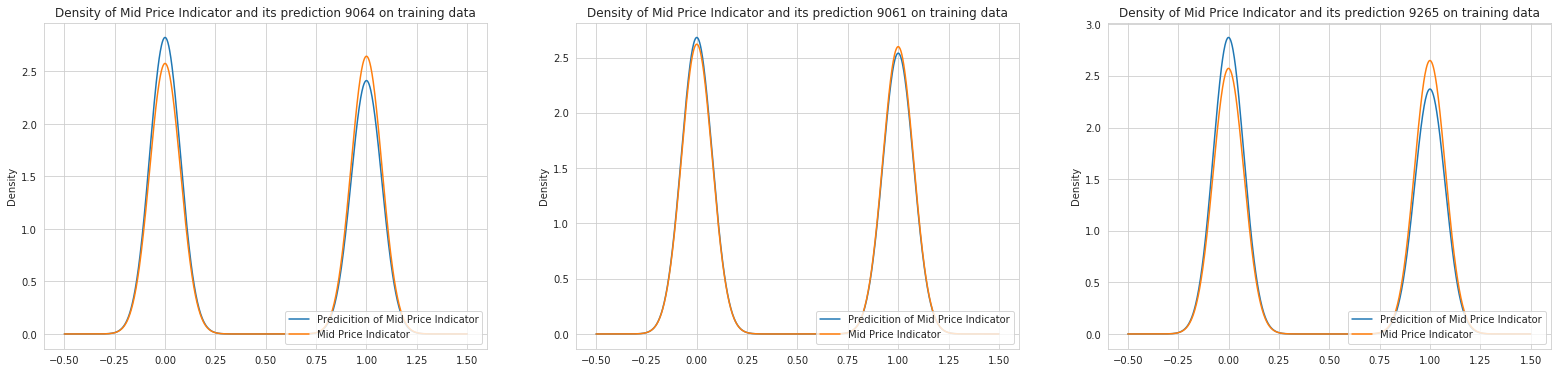

In [18]:
f, ax = plt.subplots(1, 3, figsize=(27,6))
for i in range(len(stocks)):
    s = stocks[i]
    d_stocks[s]['Predicition of Mid Price Indicator'] = d_stocks[s]['pred_log']
    d_stocks[s]['Mid Price Indicator'] = d_stocks[s]['mid_price_indicator']
    d_stocks[s][['Predicition of Mid Price Indicator', 'Mid Price Indicator']].plot(
        kind='kde', ax=ax[i])
    ax[i].set_title('Density of Mid Price Indicator and its prediction {} on training data'.format(s))
    ax[i].legend(loc='lower right')
if should_save_fig:
    print('Saving')
    plt.savefig('density_of_mid_price_and_prediction_training_data_svm.png')

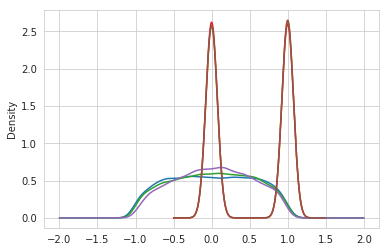

In [19]:
for s in stocks:
    d_stocks[s]['queue_imbalance'].plot(kind='kde')
    d_stocks[s]['mid_price_indicator'].plot(kind='kde')

In [20]:
df_scores[['train_matthews', 'matthews', 'test_matthews']]

,train_matthews,matthews,test_matthews
9064,0.074126,0.082146,0.088884
9061,0.090309,0.100392,0.063311
9265,0.107963,0.105674,0.117860


In [21]:
print('all 3')
df_scores[['train_roc_auc', 'roc_auc', 'test_roc_auc']]

all 3


,train_roc_auc,roc_auc,test_roc_auc
9064,0.536936,0.540714,0.544286
9061,0.543193,0.546713,0.531581
9265,0.553952,0.552374,0.558574


In [22]:
print(df_scores[['train_matthews', 'matthews', 'test_matthews', 
                 'train_roc_auc', 'roc_auc', 'test_roc_auc']].to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  train\_matthews &  matthews &  test\_matthews &  train\_roc\_auc &   roc\_auc &  test\_roc\_auc \\
\midrule
9064 &        0.074126 &  0.082146 &       0.088884 &       0.536936 &  0.540714 &      0.544286 \\
9061 &        0.090309 &  0.100392 &       0.063311 &       0.543193 &  0.546713 &      0.531581 \\
9265 &        0.107963 &  0.105674 &       0.117860 &       0.553952 &  0.552374 &      0.558574 \\
\bottomrule
\end{tabular}



In [23]:
print(df_scores[['f1', 'test_f1_score', 'precision', 'test_precision', 'recall', 'test_recall']].to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &        f1 &  test\_f1\_score &  precision &  test\_precision &    recall &  test\_recall \\
\midrule
9064 &  0.532262 &       0.527442 &   0.554853 &        0.557257 &  0.536294 &     0.500655 \\
9061 &  0.476378 &       0.513176 &   0.563588 &        0.530086 &  0.441998 &     0.497312 \\
9265 &  0.564119 &       0.533145 &   0.560195 &        0.566292 &  0.572780 &     0.503664 \\
\bottomrule
\end{tabular}



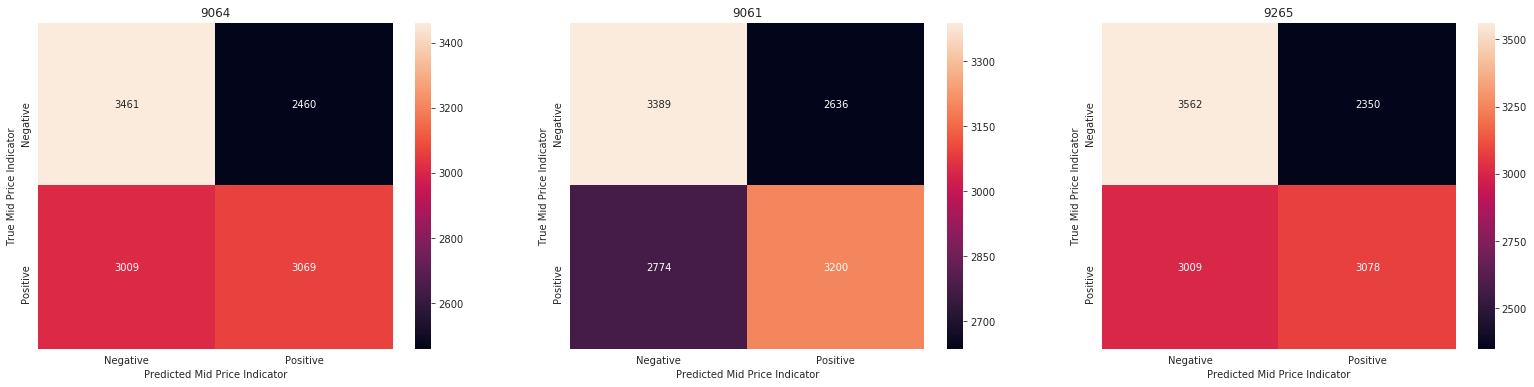

In [24]:
f, ax = plt.subplots(1, 3, figsize=(27,6))
for i in range(len(stocks)):
    stock = stocks[i]
    d_stocks[stock]['Predicition of Mid Price Indicator'] = d_stocks[stock]['pred_log']
    d_stocks[stock]['Mid Price Indicator'] = d_stocks[stock]['mid_price_indicator']
    sns.heatmap(metrics.confusion_matrix(d_stocks[stock]['mid_price_indicator'], d_stocks[stock]['pred_log']), 
               ax=ax[i], annot=True, fmt='d', xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'])
    
    ax[i].set_title('{}'.format(stock))
    ax[i].set_ylabel('True Mid Price Indicator')
    ax[i].set_xlabel('Predicted Mid Price Indicator')
if should_save_fig:
    print('Saving figure')
    plt.savefig('svm_confusion_matrix.png')

In [25]:
df_best_svm

,Unnamed: 0,c,coef0,f1,features,gamma,kappa,matthews,method,precision,recall,roc_auc,stock,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
69,69.0,1.0,1.0,0.530123,queue_imbalance,0.1,0.089783,0.090322,svm_sigmoid,0.554969,0.509007,0.544999,9064,0.532894,0.084606,0.085056,0.554890,0.513708,0.542376
309,309.0,10.0,NaN,0.472840,queue_imbalance,0.1,0.083457,0.084116,svm_rbf,0.489507,0.460222,0.541780,9061,0.465221,0.082093,0.082218,0.477822,0.453403,0.540977
69,69.0,1.0,1.0,0.557741,queue_imbalance,0.1,0.103891,0.104873,svm_sigmoid,0.561875,0.558804,0.551917,9265,0.554848,0.104753,0.104827,0.550536,0.559560,0.552398


In [27]:
print('Pivot values')
for i in range(len(stocks)):
    stock = stocks[i]
    df = d_stocks[stock]
    print(np.min(df[df['pred_log'] == 1]['queue_imbalance']), np.max(df[df['pred_log'] == 0]['queue_imbalance']))

Pivot values
0.07172856789920119 0.07142210226963971
0.04723665564478035 0.046612372205856865
0.10642146517937896 0.10636758321273516


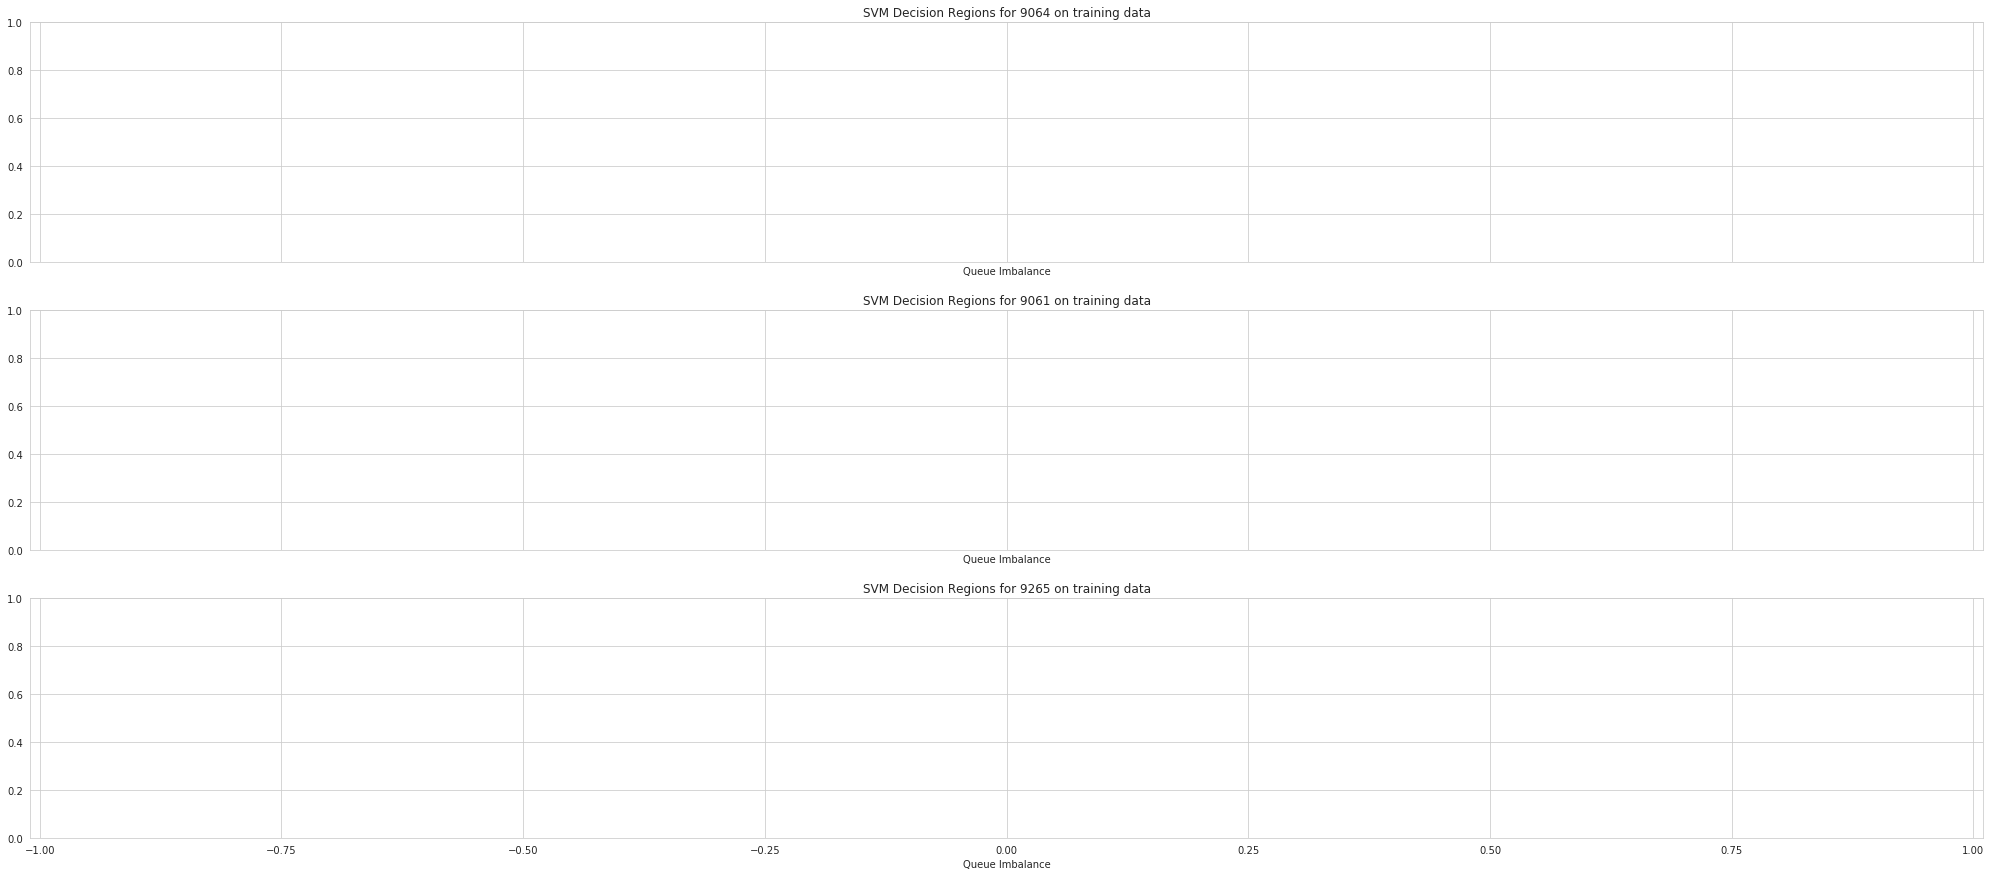

In [26]:
f, ax = plt.subplots(3, 1, figsize=(35, 15), sharex=True)
i = 0

for i in range(len(stocks)):
    s = stocks[i]
    df = d_stocks[s]
    X = d_stocks[s][['queue_imbalance']].values
    y = d_stocks[s]['mid_price_indicator'].values.astype(np.integer)

    clf = fit_best_svm_classifier(df_best_svm, d_stocks[s], stock=s)
    # plot_decision_regions(X[0:1500], y[0:1500], clf=clf,ax=ax[i], colors=','.join(['orange', 'blue']))
    ax[i].set_xlabel('Queue Imbalance')
    ax[i].set_title('SVM Decision Regions for {} on training data'.format(s))
    ax[i].set_xlim(-1.01, 1.01)

if should_save_fig:
    print('Saving')
    plt.savefig('svm_decision_region.png')

## Compare Queue Imbalance vs Prev Queue Imblanace